In [1]:
user_data = sc.textFile("./data/ml-100k/u.user")
user_fields = user_data.map(lambda line:line.split("|"))
num_users = user_fields.map(lambda fields:fields[0]).count()
num_genders = user_fields.map(lambda fields:fields[2]).distinct().count()
num_occupations = user_fields.map(lambda fields:fields[3]).distinct().count()
num_zipcodes = user_fields.map(lambda fields:fields[4]).distinct().count()
print "Users:",num_users,",genders:",num_genders,",occupations:",num_occupations,",zip codes:",num_zipcodes


Users: 943 ,genders: 2 ,occupations: 21 ,zip codes: 795


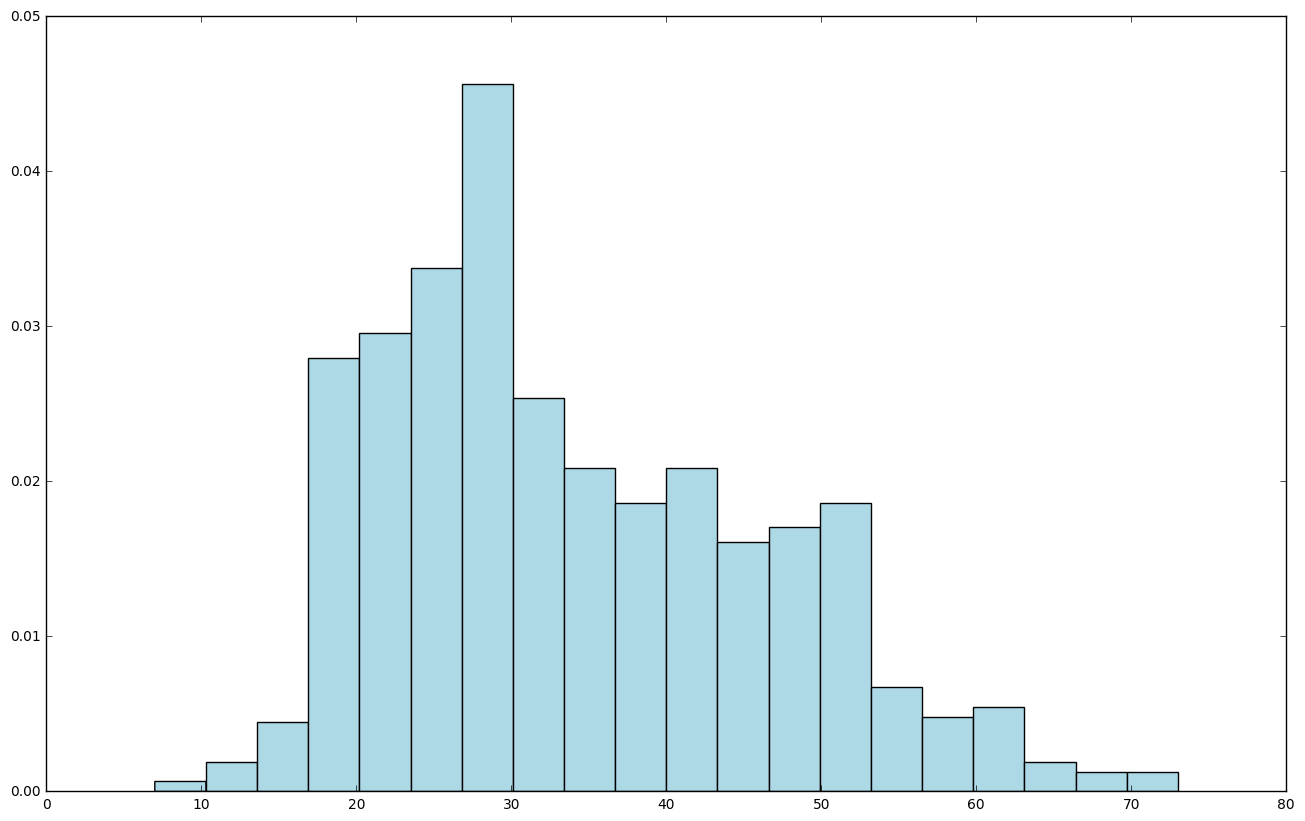

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
ages = user_fields.map(lambda x:int(x[1])).collect()
plt.hist(ages,bins=20,color='lightblue',normed=True)
fig = plt.gcf()
fig.set_size_inches(16,10)

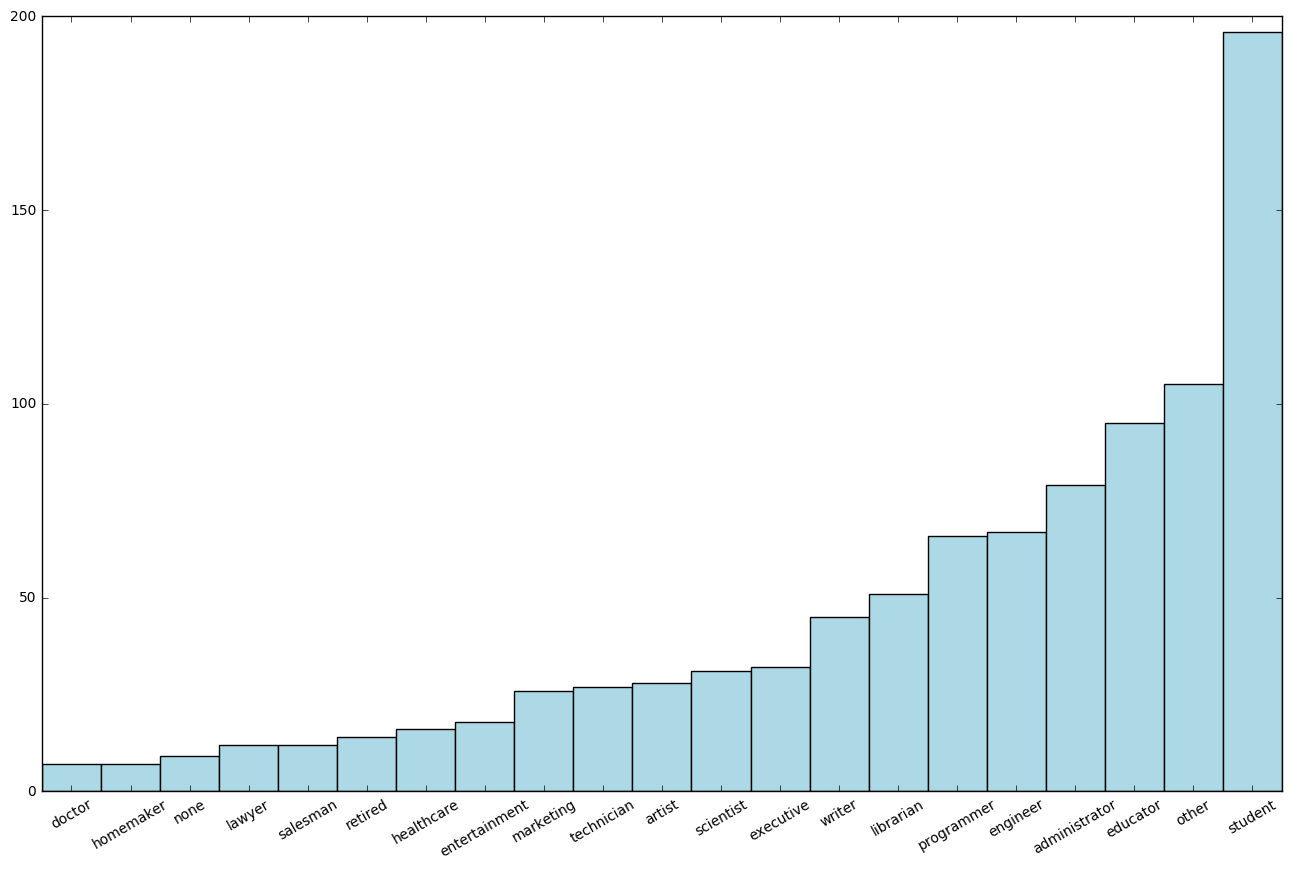

In [3]:
import numpy as np
count_by_occupation = user_fields.map(lambda fields: (fields[3], 1)).reduceByKey(lambda x, y: x + y).collect()
x_axis1 = np.array([c[0] for c in count_by_occupation])
y_axis1 = np.array([c[1] for c in count_by_occupation])
x_axis = x_axis1[np.argsort(y_axis1)]
y_axis = y_axis1[np.argsort(y_axis1)]

pos = np.arange(len(x_axis))
width = 1.0

ax = plt.axes()
ax.set_xticks(pos + (width / 2))
ax.set_xticklabels(x_axis)

plt.bar(pos, y_axis, width, color='lightblue')
plt.xticks(rotation=30)
fig = plt.gcf()
fig.set_size_inches(16, 10)

In [4]:
count_by_occupation2 = user_fields.map(lambda fields: fields[3]).countByValue()
print "Map-reduce approach:"
print dict(count_by_occupation2)
print ""
print "countByValue approach:"
print dict(count_by_occupation)

Map-reduce approach:
{u'administrator': 79, u'retired': 14, u'lawyer': 12, u'healthcare': 16, u'marketing': 26, u'executive': 32, u'scientist': 31, u'student': 196, u'technician': 27, u'librarian': 51, u'programmer': 66, u'salesman': 12, u'homemaker': 7, u'engineer': 67, u'none': 9, u'doctor': 7, u'writer': 45, u'entertainment': 18, u'other': 105, u'educator': 95, u'artist': 28}

countByValue approach:
{u'administrator': 79, u'writer': 45, u'retired': 14, u'lawyer': 12, u'doctor': 7, u'marketing': 26, u'executive': 32, u'none': 9, u'entertainment': 18, u'healthcare': 16, u'scientist': 31, u'student': 196, u'educator': 95, u'technician': 27, u'librarian': 51, u'programmer': 66, u'artist': 28, u'salesman': 12, u'other': 105, u'homemaker': 7, u'engineer': 67}


In [6]:
movie_data = sc.textFile("%s/ml-100k/u.item" % "./data")
print movie_data.first()
num_movies = movie_data.count()
print "Movies: %d" % num_movies

1|Toy Story (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)|0|0|0|1|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0
Movies: 1682


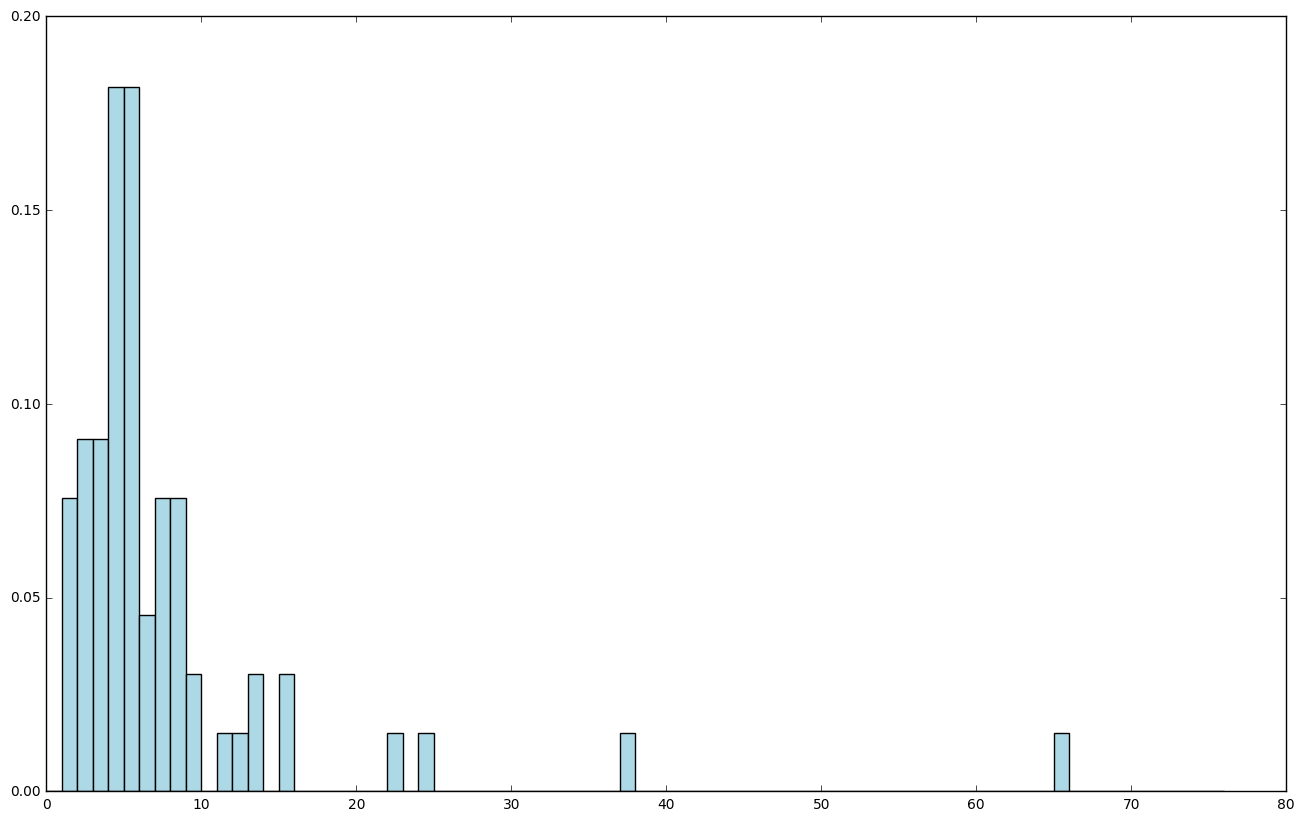

In [7]:
def convert_year(x):
    try:
        return int(x[-4:])
    except:
        return 1900 
movie_fields = movie_data.map(lambda lines: lines.split("|"))
years = movie_fields.map(lambda fields: fields[2]).map(lambda x: convert_year(x))
years_filtered = years.filter(lambda x: x != 1900)
movie_ages = years_filtered.map(lambda yr: 1998-yr).countByValue()
values = movie_ages.values()
bins = movie_ages.keys()
plt.hist(values, bins=bins, color='lightblue', normed=True)
fig = plt.gcf()
fig.set_size_inches(16,10)

In [8]:
rating_data_raw = sc.textFile("%s/ml-100k/u.data" % "./data")
print rating_data_raw.first()
num_ratings = rating_data_raw.count()
print "Ratings: %d" % num_ratings

196	242	3	881250949
Ratings: 100000


In [9]:
rating_data = rating_data_raw.map(lambda line: line.split("\t"))
ratings = rating_data.map(lambda fields: int(fields[2]))
max_rating = ratings.reduce(lambda x, y: max(x, y))
min_rating = ratings.reduce(lambda x, y: min(x, y))
mean_rating = ratings.reduce(lambda x, y: x + y) / float(num_ratings)
median_rating = np.median(ratings.collect())
ratings_per_user = num_ratings / num_users
ratings_per_movie = num_ratings / num_movies
print "Min rating: %d" % min_rating
print "Max rating: %d" % max_rating
print "Average rating: %2.2f" % mean_rating
print "Median rating: %d" % median_rating
print "Average # of ratings per user: %2.2f" % ratings_per_user
print "Average # of ratings per movie: %2.2f" % ratings_per_movie


Min rating: 1
Max rating: 5
Average rating: 3.53
Median rating: 4
Average # of ratings per user: 106.00
Average # of ratings per movie: 59.00


In [10]:
ratings.stats()

(count: 100000, mean: 3.52986, stdev: 1.12566797076, max: 5.0, min: 1.0)

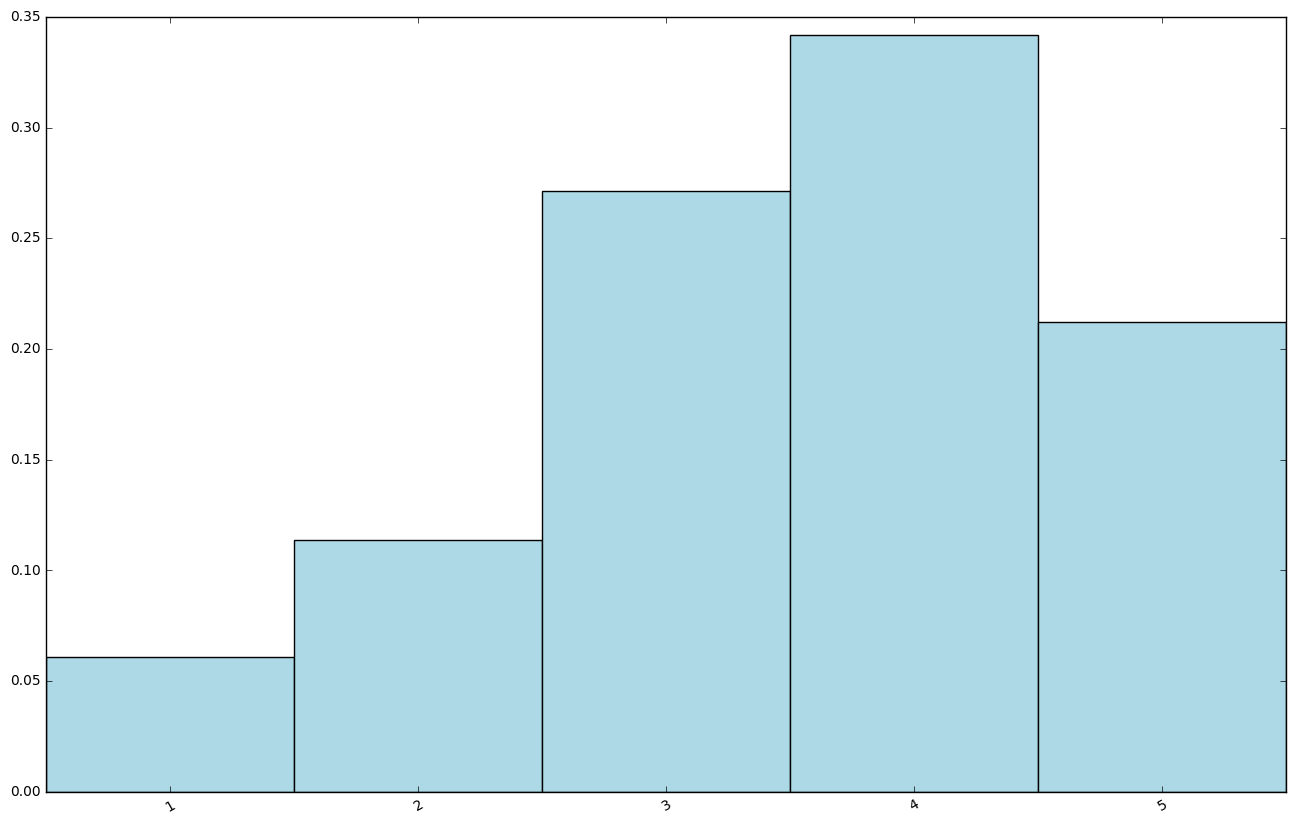

In [11]:
count_by_rating = ratings.countByValue()
x_axis = np.array(count_by_rating.keys())
y_axis = np.array([float(c) for c in count_by_rating.values()])
y_axis_normed = y_axis / y_axis.sum()

pos = np.arange(len(x_axis))
width = 1.0

ax = plt.axes()
ax.set_xticks(pos + (width / 2))
ax.set_xticklabels(x_axis)

plt.bar(pos, y_axis_normed, width, color='lightblue')
plt.xticks(rotation=30)
fig = plt.gcf()
fig.set_size_inches(16, 10)

In [13]:
# to compute the distribution of ratings per user, we first group the ratings by user id
user_ratings_grouped = rating_data.map(lambda fields: (int(fields[0]), int(fields[2]))).groupByKey() 
# then, for each key (user id), we find the size of the set of ratings, which gives us the # ratings for that user 
user_ratings_byuser = user_ratings_grouped.map(lambda (k, v): (k, len(v)))
user_ratings_byuser.first()


(2, 62)

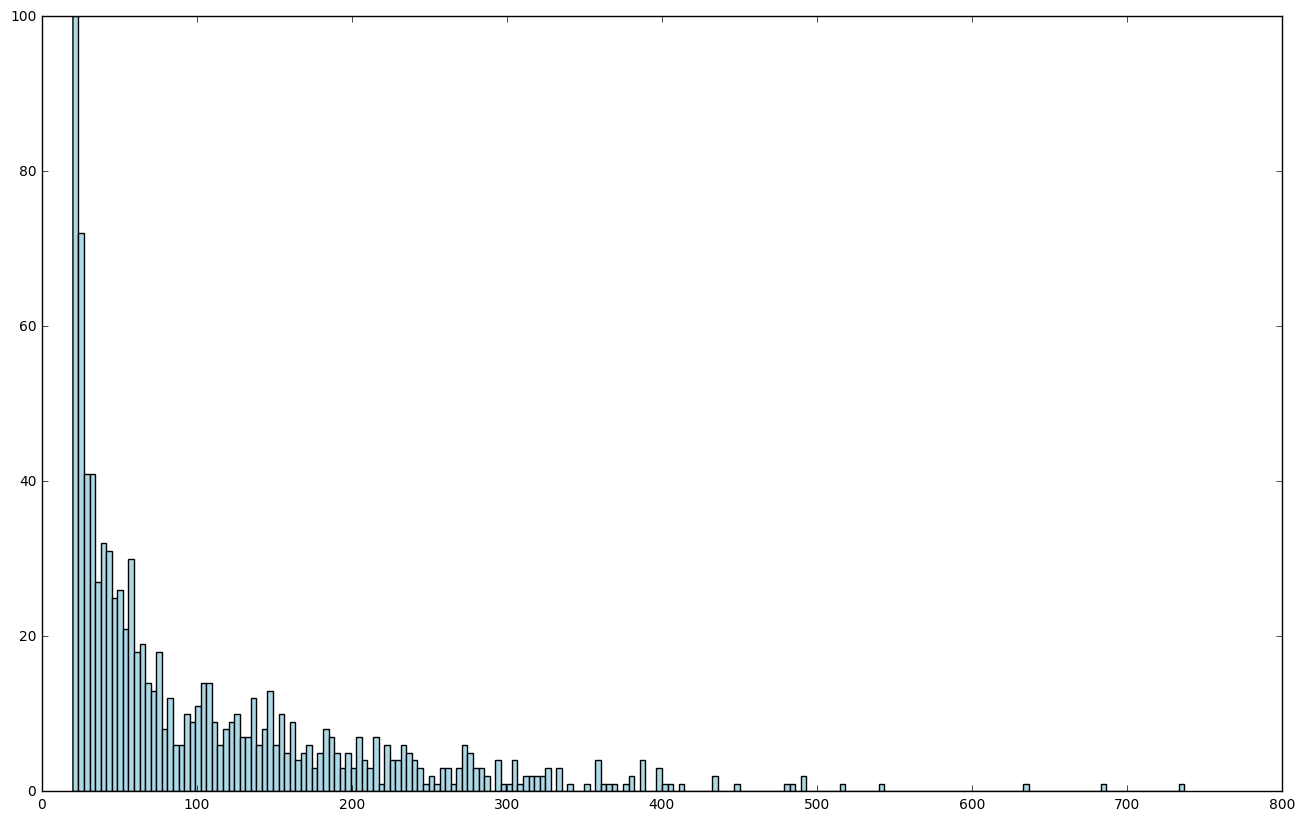

In [19]:
user_ratings_byuser_local = user_ratings_byuser.map(lambda (k, v): v).collect()
plt.hist(user_ratings_byuser_local, bins=200, color='lightblue', normed=False)
fig = plt.gcf()
fig.set_size_inches(16,10)